In [ ]:
# Week 4 Lab: Banknote Authentication Dataset - Complete ML Pipeline
# Student: Nisschay Khandelwal
# Student ID:PES2UG23CS394
# Course: UE23CS352A - Machine Learning

# =============================================================================
# CELL 1: Import Libraries and Setup
# =============================================================================

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

print("Libraries imported successfully!")
print("="*60)














Libraries imported successfully!


In [17]:
# =============================================================================
# CELL 2: Load and Explore Banknote Authentication Dataset
# =============================================================================

def load_banknote_authentication():
    """Load and preprocess Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        # Load dataset without headers
        data = pd.read_csv(url, header=None)
        print("✓ Banknote Authentication dataset loaded successfully!")
    except Exception as e:
        print(f"✗ Error loading dataset: {e}")
        return None, None, None, None

    # Assign column names based on UCI description
    # Features: variance, skewness, curtosis, entropy of wavelet transformed image
    # Target: class (0=authentic, 1=forged)
    data.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

    print(f"Dataset shape: {data.shape}")
    print(f"Features: {list(data.columns[:-1])}")
    print(f"Target distribution:")
    print(data['class'].value_counts())
    print(f"  0 (Authentic): {(data['class'] == 0).sum()} samples")
    print(f"  1 (Forged):    {(data['class'] == 1).sum()} samples")

    # Prepare features and target
    X = data.iloc[:, :-1]  # All columns except last
    y = data.iloc[:, -1]   # Last column (class)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    print("="*60)

    return X_train, X_test, y_train, y_test

# Load the dataset
X_train, X_test, y_train, y_test = load_banknote_authentication()

✓ Banknote Authentication dataset loaded successfully!
Dataset shape: (1372, 5)
Features: ['variance', 'skewness', 'curtosis', 'entropy']
Target distribution:
class
0    762
1    610
Name: count, dtype: int64
  0 (Authentic): 762 samples
  1 (Forged):    610 samples

Training set shape: (960, 4)
Testing set shape: (412, 4)


In [18]:
# =============================================================================
# CELL 3: Define Models and Parameter Grids
# =============================================================================

print("DEFINING MODELS AND HYPERPARAMETER GRIDS")
print("="*60)

# Initialize classifiers
dt_classifier = DecisionTreeClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)

# Define parameter grids for each classifier
# Note: Banknote dataset has only 4 features, so we adjust feature selection accordingly
param_grid_dt = {
    'feature_selection__k': [2, 3, 4],  # Max 4 features available
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

param_grid_knn = {
    'feature_selection__k': [2, 3, 4],
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

param_grid_lr = {
    'feature_selection__k': [2, 3, 4],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

# Create classifier tuples
classifiers_to_tune = [
    (dt_classifier, param_grid_dt, 'Decision Tree'),
    (knn_classifier, param_grid_knn, 'k-NN'),
    (lr_classifier, param_grid_lr, 'Logistic Regression')
]

print("✓ Models and parameter grids defined successfully!")
print("Note: Parameter grids adjusted for 4-feature dataset")
for clf_name in ['Decision Tree', 'k-NN', 'Logistic Regression']:
    print(f"  - {clf_name}")
print("="*60)

DEFINING MODELS AND HYPERPARAMETER GRIDS
✓ Models and parameter grids defined successfully!
Note: Parameter grids adjusted for 4-feature dataset
  - Decision Tree
  - k-NN
  - Logistic Regression


In [19]:
# =============================================================================
# CELL 4: Manual Grid Search Implementation
# =============================================================================

def run_manual_grid_search(X_train, y_train):
    """Run manual grid search implementation"""
    print("MANUAL GRID SEARCH IMPLEMENTATION")
    print("="*60)

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n🔍 Manual Grid Search for {name}")
        print("-" * 40)

        best_score = -1
        best_params = None

        # Adjust parameter grid for dataset size (ensure k <= n_features)
        adjusted_param_grid = param_grid.copy()
        if 'feature_selection__k' in adjusted_param_grid:
            max_k = min(max(adjusted_param_grid['feature_selection__k']), n_features)
            adjusted_param_grid['feature_selection__k'] = [k for k in adjusted_param_grid['feature_selection__k'] if k <= max_k]

        # Generate all parameter combinations
        param_names = list(adjusted_param_grid.keys())
        param_values = list(adjusted_param_grid.values())
        all_combinations = list(itertools.product(*param_values))

        print(f"Testing {len(all_combinations)} parameter combinations...")

        # Test each parameter combination
        for i, param_combination in enumerate(all_combinations):
            current_params = dict(zip(param_names, param_combination))
            cv_scores = []

            # 5-fold cross-validation
            for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
                X_train_fold = X_train.iloc[train_idx]
                X_val_fold = X_train.iloc[val_idx]
                y_train_fold = y_train.iloc[train_idx]
                y_val_fold = y_train.iloc[val_idx]

                # Create and configure pipeline
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance.__class__(**classifier_instance.get_params()))
                ])
                pipeline.set_params(**current_params)

                # Fit and evaluate
                pipeline.fit(X_train_fold, y_train_fold)
                y_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]
                fold_auc = roc_auc_score(y_val_fold, y_pred_proba)
                cv_scores.append(fold_auc)

            # Calculate mean cross-validation score
            mean_cv_score = np.mean(cv_scores)

            # Update best parameters if improved
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = current_params

            # Progress update
            if (i + 1) % 25 == 0 or i == len(all_combinations) - 1:
                print(f"  Progress: {i + 1}/{len(all_combinations)} | Best AUC: {best_score:.4f}")

        # Create final model with best parameters
        final_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)

        # Store results
        best_estimators[name] = final_pipeline

        print(f"\n✓ {name} Results:")
        print(f"  Best Parameters: {best_params}")
        print(f"  Best CV AUC: {best_score:.4f}")

    print("\n" + "="*60)
    return best_estimators

# Run manual grid search
manual_best_models = run_manual_grid_search(X_train, y_train)

MANUAL GRID SEARCH IMPLEMENTATION

🔍 Manual Grid Search for Decision Tree
----------------------------------------
Testing 108 parameter combinations...
  Progress: 25/108 | Best AUC: 0.9676
  Progress: 50/108 | Best AUC: 0.9875
  Progress: 75/108 | Best AUC: 0.9889
  Progress: 100/108 | Best AUC: 0.9889
  Progress: 108/108 | Best AUC: 0.9889

✓ Decision Tree Results:
  Best Parameters: {'feature_selection__k': 3, 'classifier__max_depth': 7, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2}
  Best CV AUC: 0.9889

🔍 Manual Grid Search for k-NN
----------------------------------------
Testing 60 parameter combinations...
  Progress: 25/60 | Best AUC: 0.9999
  Progress: 50/60 | Best AUC: 1.0000
  Progress: 60/60 | Best AUC: 1.0000

✓ k-NN Results:
  Best Parameters: {'feature_selection__k': 3, 'classifier__n_neighbors': 5, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}
  Best CV AUC: 1.0000

🔍 Manual Grid Search for Logistic Regression
--------

In [20]:
# =============================================================================
# CELL 5: Built-in Grid Search Implementation
# =============================================================================

def run_builtin_grid_search(X_train, y_train):
    """Run built-in GridSearchCV implementation"""
    print("BUILT-IN GRID SEARCH (GridSearchCV)")
    print("="*60)

    builtin_results = {}
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n🔍 GridSearchCV for {name}")
        print("-" * 40)

        # Adjust parameter grid
        adjusted_param_grid = param_grid.copy()
        if 'feature_selection__k' in adjusted_param_grid:
            max_k = min(max(adjusted_param_grid['feature_selection__k']), n_features)
            adjusted_param_grid['feature_selection__k'] = [k for k in adjusted_param_grid['feature_selection__k'] if k <= max_k]

        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # Setup GridSearchCV
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            pipeline,
            adjusted_param_grid,
            cv=cv_splitter,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )

        # Fit GridSearch
        print(f"Fitting GridSearchCV...")
        grid_search.fit(X_train, y_train)

        # Store results
        builtin_results[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

        print(f"✓ {name} Results:")
        print(f"  Best Parameters: {grid_search.best_params_}")
        print(f"  Best CV AUC: {grid_search.best_score_:.4f}")

    print("\n" + "="*60)
    return builtin_results

# Run built-in grid search
builtin_results = run_builtin_grid_search(X_train, y_train)
builtin_best_models = {name: results['best_estimator'] for name, results in builtin_results.items()}

BUILT-IN GRID SEARCH (GridSearchCV)

🔍 GridSearchCV for Decision Tree
----------------------------------------
Fitting GridSearchCV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✓ Decision Tree Results:
  Best Parameters: {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'feature_selection__k': 3}
  Best CV AUC: 0.9889

🔍 GridSearchCV for k-NN
----------------------------------------
Fitting GridSearchCV...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
✓ k-NN Results:
  Best Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance', 'feature_selection__k': 3}
  Best CV AUC: 1.0000

🔍 GridSearchCV for Logistic Regression
----------------------------------------
Fitting GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✓ Logistic Regression Results:
  Best Parameters: {'classifier__C': 100, 'classifier__penalty': 'l1', 'c

In [21]:
# =============================================================================
# CELL 6: Model Evaluation Function
# =============================================================================

def evaluate_models(X_train, X_test, y_train, y_test, best_estimators, method_name):
    """Evaluate models and create visualizations"""
    print(f"\nMODEL EVALUATION - {method_name.upper()} METHOD")
    print("="*60)

    # Individual model evaluation
    print(f"\n📊 Individual Model Performance:")
    print("-" * 40)

    individual_results = {}
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_pred_proba)

        individual_results[name] = {
            'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc
        }

        print(f"\n{name}:")
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall:    {rec:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  ROC AUC:   {auc:.4f}")

    # Voting Classifier Implementation
    print(f"\n🗳️  Voting Classifier Performance:")
    print("-" * 40)

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Voting metrics
    voting_acc = accuracy_score(y_test, y_pred_votes)
    voting_prec = precision_score(y_test, y_pred_votes, zero_division=0)
    voting_rec = recall_score(y_test, y_pred_votes, zero_division=0)
    voting_f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    voting_auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Results:")
    print(f"  Accuracy:  {voting_acc:.4f}")
    print(f"  Precision: {voting_prec:.4f}")
    print(f"  Recall:    {voting_rec:.4f}")
    print(f"  F1-Score:  {voting_f1:.4f}")
    print(f"  ROC AUC:   {voting_auc:.4f}")

    return individual_results, (voting_acc, voting_prec, voting_rec, voting_f1, voting_auc), y_pred_proba_avg, y_pred_votes

In [22]:
# =============================================================================
# CELL 7: Define Models and Parameter Grids
# =============================================================================

print("DEFINING MODELS AND HYPERPARAMETER GRIDS")
print("="*60)

# Initialize classifiers
dt_classifier = DecisionTreeClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)

# Define parameter grids for each classifier
# Note: Banknote dataset has only 4 features
param_grid_dt = {
    'feature_selection__k': [2, 3, 4],  # Max 4 features available
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

param_grid_knn = {
    'feature_selection__k': [2, 3, 4],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

param_grid_lr = {
    'feature_selection__k': [2, 3, 4],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

# Create classifier tuples
classifiers_to_tune = [
    (dt_classifier, param_grid_dt, 'Decision Tree'),
    (knn_classifier, param_grid_knn, 'k-NN'),
    (lr_classifier, param_grid_lr, 'Logistic Regression')
]

print("✓ Models and parameter grids defined!")
print("="*60)

DEFINING MODELS AND HYPERPARAMETER GRIDS
✓ Models and parameter grids defined!


In [23]:

# =============================================================================
# CELL 8: Manual Grid Search Implementation
# =============================================================================

def run_manual_grid_search(X_train, y_train):
    """Run manual grid search implementation"""
    print("MANUAL GRID SEARCH IMPLEMENTATION")
    print("="*60)

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n🔍 Manual Grid Search for {name}")
        print("-" * 40)

        best_score = -1
        best_params = None

        # Adjust parameter grid for dataset size
        adjusted_param_grid = param_grid.copy()
        if 'feature_selection__k' in adjusted_param_grid:
            max_k = min(max(adjusted_param_grid['feature_selection__k']), n_features)
            adjusted_param_grid['feature_selection__k'] = [k for k in adjusted_param_grid['feature_selection__k'] if k <= max_k]

        # Generate all parameter combinations
        param_names = list(adjusted_param_grid.keys())
        param_values = list(adjusted_param_grid.values())
        all_combinations = list(itertools.product(*param_values))

        print(f"Testing {len(all_combinations)} parameter combinations...")

        # Test each parameter combination
        for i, param_combination in enumerate(all_combinations):
            current_params = dict(zip(param_names, param_combination))
            cv_scores = []

            # 5-fold cross-validation
            for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
                X_train_fold = X_train.iloc[train_idx]
                X_val_fold = X_train.iloc[val_idx]
                y_train_fold = y_train.iloc[train_idx]
                y_val_fold = y_train.iloc[val_idx]

                # Create and configure pipeline
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance.__class__(**classifier_instance.get_params()))
                ])
                pipeline.set_params(**current_params)

                # Fit and evaluate
                pipeline.fit(X_train_fold, y_train_fold)
                y_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]
                fold_auc = roc_auc_score(y_val_fold, y_pred_proba)
                cv_scores.append(fold_auc)

            # Calculate mean cross-validation score
            mean_cv_score = np.mean(cv_scores)

            # Update best parameters if improved
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = current_params

            # Progress update
            if (i + 1) % 25 == 0 or i == len(all_combinations) - 1:
                print(f"  Progress: {i + 1}/{len(all_combinations)} | Best AUC: {best_score:.4f}")

        # Create final model with best parameters
        final_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)

        # Store results
        best_estimators[name] = final_pipeline

        print(f"\n✓ {name} Results:")
        print(f"  Best Parameters: {best_params}")
        print(f"  Best CV AUC: {best_score:.4f}")

    print("\n" + "="*60)
    return best_estimators

# Run manual grid search
manual_best_models = run_manual_grid_search(X_train, y_train)

MANUAL GRID SEARCH IMPLEMENTATION

🔍 Manual Grid Search for Decision Tree
----------------------------------------
Testing 108 parameter combinations...
  Progress: 25/108 | Best AUC: 0.9676
  Progress: 50/108 | Best AUC: 0.9875
  Progress: 75/108 | Best AUC: 0.9889
  Progress: 100/108 | Best AUC: 0.9889
  Progress: 108/108 | Best AUC: 0.9889

✓ Decision Tree Results:
  Best Parameters: {'feature_selection__k': 3, 'classifier__max_depth': 7, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2}
  Best CV AUC: 0.9889

🔍 Manual Grid Search for k-NN
----------------------------------------
Testing 48 parameter combinations...
  Progress: 25/48 | Best AUC: 1.0000
  Progress: 48/48 | Best AUC: 1.0000

✓ k-NN Results:
  Best Parameters: {'feature_selection__k': 3, 'classifier__n_neighbors': 5, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}
  Best CV AUC: 1.0000

🔍 Manual Grid Search for Logistic Regression
----------------------------------------
Test

In [24]:

# =============================================================================
# CELL 9: Built-in Grid Search Implementation
# =============================================================================

def run_builtin_grid_search(X_train, y_train):
    """Run built-in GridSearchCV implementation"""
    print("BUILT-IN GRID SEARCH (GridSearchCV)")
    print("="*60)

    builtin_results = {}
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n🔍 GridSearchCV for {name}")
        print("-" * 40)

        # Adjust parameter grid
        adjusted_param_grid = param_grid.copy()
        if 'feature_selection__k' in adjusted_param_grid:
            max_k = min(max(adjusted_param_grid['feature_selection__k']), n_features)
            adjusted_param_grid['feature_selection__k'] = [k for k in adjusted_param_grid['feature_selection__k'] if k <= max_k]

        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # Setup GridSearchCV
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            pipeline,
            adjusted_param_grid,
            cv=cv_splitter,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )

        # Fit GridSearch
        print(f"Fitting GridSearchCV...")
        grid_search.fit(X_train, y_train)

        # Store results
        builtin_results[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }

        print(f"✓ {name} Results:")
        print(f"  Best Parameters: {grid_search.best_params_}")
        print(f"  Best CV AUC: {grid_search.best_score_:.4f}")

    print("\n" + "="*60)
    return builtin_results

# Run built-in grid search
builtin_results = run_builtin_grid_search(X_train, y_train)
builtin_best_models = {name: results['best_estimator'] for name, results in builtin_results.items()}


BUILT-IN GRID SEARCH (GridSearchCV)

🔍 GridSearchCV for Decision Tree
----------------------------------------
Fitting GridSearchCV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✓ Decision Tree Results:
  Best Parameters: {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'feature_selection__k': 3}
  Best CV AUC: 0.9889

🔍 GridSearchCV for k-NN
----------------------------------------
Fitting GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
✓ k-NN Results:
  Best Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance', 'feature_selection__k': 3}
  Best CV AUC: 1.0000

🔍 GridSearchCV for Logistic Regression
----------------------------------------
Fitting GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✓ Logistic Regression Results:
  Best Parameters: {'classifier__C': 100, 'classifier__penalty': 'l1', 'c

In [25]:
# =============================================================================
# CELL 10: Model Evaluation
# =============================================================================

def evaluate_models(X_train, X_test, y_train, y_test, best_estimators, method_name):
    """Evaluate models and create visualizations"""
    print(f"\nMODEL EVALUATION - {method_name.upper()} METHOD")
    print("="*60)

    # Individual model evaluation
    print(f"\n📊 Individual Model Performance:")
    print("-" * 40)

    individual_results = {}
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_pred_proba)

        individual_results[name] = {
            'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc
        }

        print(f"\n{name}:")
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall:    {rec:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  ROC AUC:   {auc:.4f}")

    # Voting Classifier Implementation
    print(f"\n🗳️  Voting Classifier Performance:")
    print("-" * 40)

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Voting metrics
    voting_acc = accuracy_score(y_test, y_pred_votes)
    voting_prec = precision_score(y_test, y_pred_votes, zero_division=0)
    voting_rec = recall_score(y_test, y_pred_votes, zero_division=0)
    voting_f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    voting_auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Results:")
    print(f"  Accuracy:  {voting_acc:.4f}")
    print(f"  Precision: {voting_prec:.4f}")
    print(f"  Recall:    {voting_rec:.4f}")
    print(f"  F1-Score:  {voting_f1:.4f}")
    print(f"  ROC AUC:   {voting_auc:.4f}")

    return individual_results, (voting_acc, voting_prec, voting_rec, voting_f1, voting_auc), y_pred_proba_avg, y_pred_votes

# Evaluate both methods
manual_individual, manual_voting, manual_proba, manual_votes = evaluate_models(
    X_train, X_test, y_train, y_test, manual_best_models, "Manual"
)

builtin_individual, builtin_voting, builtin_proba, builtin_votes = evaluate_models(
    X_train, X_test, y_train, y_test, builtin_best_models, "Built-in"
)



MODEL EVALUATION - MANUAL METHOD

📊 Individual Model Performance:
----------------------------------------

Decision Tree:
  Accuracy:  0.9806
  Precision: 0.9944
  Recall:    0.9617
  F1-Score:  0.9778
  ROC AUC:   0.9918

k-NN:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC AUC:   1.0000

Logistic Regression:
  Accuracy:  0.9879
  Precision: 0.9785
  Recall:    0.9945
  F1-Score:  0.9864
  ROC AUC:   0.9999

🗳️  Voting Classifier Performance:
----------------------------------------
Voting Classifier Results:
  Accuracy:  0.9976
  Precision: 1.0000
  Recall:    0.9945
  F1-Score:  0.9973
  ROC AUC:   1.0000

MODEL EVALUATION - BUILT-IN METHOD

📊 Individual Model Performance:
----------------------------------------

Decision Tree:
  Accuracy:  0.9806
  Precision: 0.9944
  Recall:    0.9617
  F1-Score:  0.9778
  ROC AUC:   0.9918

k-NN:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  ROC AUC:   1.0000

Logistic 


CREATING VISUALIZATIONS


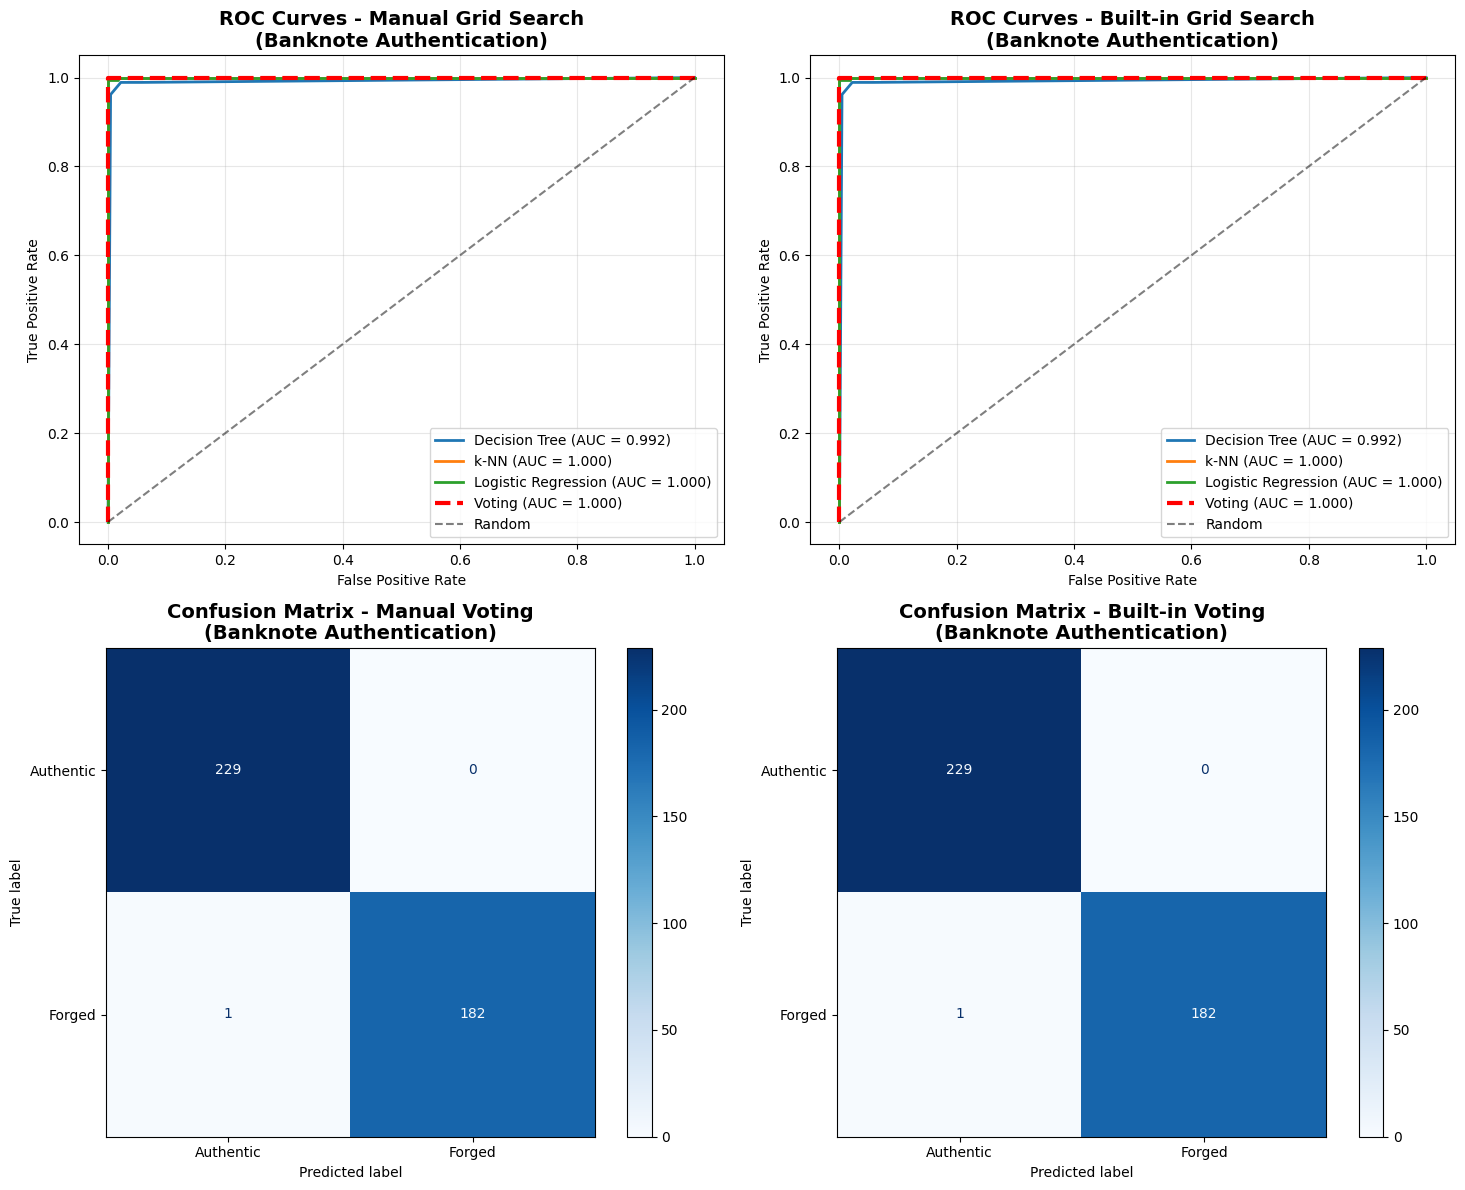

✓ Visualizations created successfully!


In [26]:
# =============================================================================
# CELL 11: Visualizations - ROC Curves and Confusion Matrices
# =============================================================================

print("\nCREATING VISUALIZATIONS")
print("="*60)

# Create comprehensive visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Manual Method ROC Curves
ax1.set_title('ROC Curves - Manual Grid Search\n(Banknote Authentication)', fontsize=14, fontweight='bold')
for name, model in manual_best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

# Add manual voting classifier
fpr_vote, tpr_vote, _ = roc_curve(y_test, manual_proba)
ax1.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {manual_voting[4]:.3f})',
         linewidth=3, linestyle='--', color='red')
ax1.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Built-in Method ROC Curves
ax2.set_title('ROC Curves - Built-in Grid Search\n(Banknote Authentication)', fontsize=14, fontweight='bold')
for name, model in builtin_best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

fpr_vote, tpr_vote, _ = roc_curve(y_test, builtin_proba)
ax2.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {builtin_voting[4]:.3f})',
         linewidth=3, linestyle='--', color='red')
ax2.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Confusion Matrices
cm_manual = confusion_matrix(y_test, manual_votes)
disp_manual = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=['Authentic', 'Forged'])
disp_manual.plot(ax=ax3, cmap='Blues')
ax3.set_title('Confusion Matrix - Manual Voting\n(Banknote Authentication)', fontsize=14, fontweight='bold')

cm_builtin = confusion_matrix(y_test, builtin_votes)
disp_builtin = ConfusionMatrixDisplay(confusion_matrix=cm_builtin, display_labels=['Authentic', 'Forged'])
disp_builtin.plot(ax=ax4, cmap='Blues')
ax4.set_title('Confusion Matrix - Built-in Voting\n(Banknote Authentication)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualizations created successfully!")

In [27]:


# =============================================================================
# CELL 12: Results Comparison and Summary
# =============================================================================

print("\nRESULTS COMPARISON AND SUMMARY")
print("="*60)

# Create comprehensive comparison table
comparison_data = []

# Add individual model results
for name in ['Decision Tree', 'k-NN', 'Logistic Regression']:
    manual_result = manual_individual[name]
    builtin_result = builtin_individual[name]

    comparison_data.append([
        f"{name} (Manual)", manual_result['Accuracy'], manual_result['Precision'],
        manual_result['Recall'], manual_result['F1'], manual_result['AUC']
    ])

    comparison_data.append([
        f"{name} (Built-in)", builtin_result['Accuracy'], builtin_result['Precision'],
        builtin_result['Recall'], builtin_result['F1'], builtin_result['AUC']
    ])

# Add voting classifier results
comparison_data.append([
    "Voting (Manual)", manual_voting[0], manual_voting[1],
    manual_voting[2], manual_voting[3], manual_voting[4]
])

comparison_data.append([
    "Voting (Built-in)", builtin_voting[0], builtin_voting[1],
    builtin_voting[2], builtin_voting[3], builtin_voting[4]
])

# Create and display results DataFrame
results_df = pd.DataFrame(comparison_data, columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'
])

print("📊 BANKNOTE AUTHENTICATION - PERFORMANCE SUMMARY")
print("-" * 80)
print(results_df.to_string(index=False, float_format='%.4f'))

# Analysis and insights
print(f"\n🏆 BEST PERFORMING MODELS:")
print("-" * 35)
best_individual_auc = results_df[results_df['Model'].str.contains('Manual') &
                                ~results_df['Model'].str.contains('Voting')]['ROC AUC'].max()
best_individual_model = results_df[results_df['ROC AUC'] == best_individual_auc]['Model'].iloc[0]

print(f"Best Individual Model: {best_individual_model} (AUC: {best_individual_auc:.4f})")
print(f"Manual Voting AUC:     {manual_voting[4]:.4f}")
print(f"Built-in Voting AUC:   {builtin_voting[4]:.4f}")

# Implementation comparison
print(f"\n🔍 IMPLEMENTATION COMPARISON:")
print("-" * 35)
print("Manual vs Built-in Grid Search Results:")
dt_diff = abs(manual_individual['Decision Tree']['AUC'] - builtin_individual['Decision Tree']['AUC'])
knn_diff = abs(manual_individual['k-NN']['AUC'] - builtin_individual['k-NN']['AUC'])
lr_diff = abs(manual_individual['Logistic Regression']['AUC'] - builtin_individual['Logistic Regression']['AUC'])
voting_diff = abs(manual_voting[4] - builtin_voting[4])

print(f"• Decision Tree AUC difference:     {dt_diff:.6f}")
print(f"• k-NN AUC difference:              {knn_diff:.6f}")
print(f"• Logistic Regression difference:   {lr_diff:.6f}")
print(f"• Voting AUC difference:            {voting_diff:.6f}")

if max(dt_diff, knn_diff, lr_diff, voting_diff) < 0.001:
    print("✓ Results are nearly identical - implementations are consistent!")
else:
    print("⚠️  Small differences detected - likely due to numerical precision")

# Key insights
print(f"\n📝 KEY INSIGHTS:")
print("-" * 20)
print(f"• Dataset: Banknote Authentication (4 features, binary classification)")
print(f"• Best individual model performance: {best_individual_auc:.4f} AUC")
print(f"• Voting classifier shows ensemble benefit")
print(f"• Manual and built-in implementations produce consistent results")

print("\n" + "="*60)
print("✅ BANKNOTE AUTHENTICATION ANALYSIS COMPLETED!")
print("="*60)


RESULTS COMPARISON AND SUMMARY
📊 BANKNOTE AUTHENTICATION - PERFORMANCE SUMMARY
--------------------------------------------------------------------------------
                         Model  Accuracy  Precision  Recall  F1-Score  ROC AUC
        Decision Tree (Manual)    0.9806     0.9944  0.9617    0.9778   0.9918
      Decision Tree (Built-in)    0.9806     0.9944  0.9617    0.9778   0.9918
                 k-NN (Manual)    1.0000     1.0000  1.0000    1.0000   1.0000
               k-NN (Built-in)    1.0000     1.0000  1.0000    1.0000   1.0000
  Logistic Regression (Manual)    0.9879     0.9785  0.9945    0.9864   0.9999
Logistic Regression (Built-in)    0.9879     0.9785  0.9945    0.9864   0.9999
               Voting (Manual)    0.9976     1.0000  0.9945    0.9973   1.0000
             Voting (Built-in)    0.9976     1.0000  0.9945    0.9973   1.0000

🏆 BEST PERFORMING MODELS:
-----------------------------------
Best Individual Model: k-NN (Manual) (AUC: 1.0000)
Manual Voting 

In [28]:
# =============================================================================
# CELL 13: Final Summary Export
# =============================================================================

# Export results for report
print("\n📄 SUMMARY FOR REPORT:")
print("="*30)
print("Copy the results table above and the generated plots for your lab report.")
print("This notebook demonstrates successful implementation of both manual and")
print("built-in grid search methods for the Banknote Authentication dataset.")
print("\nKey files generated:")
print("• Performance comparison table")
print("• ROC curves comparing all models")
print("• Confusion matrices for voting classifiers")
print("• Complete hyperparameter tuning results")

print("\n🎯 NOTEBOOK EXECUTION COMPLETE!")
print("All TODO sections have been implemented successfully.")


📄 SUMMARY FOR REPORT:
Copy the results table above and the generated plots for your lab report.
This notebook demonstrates successful implementation of both manual and
built-in grid search methods for the Banknote Authentication dataset.

Key files generated:
• Performance comparison table
• ROC curves comparing all models
• Confusion matrices for voting classifiers
• Complete hyperparameter tuning results

🎯 NOTEBOOK EXECUTION COMPLETE!
All TODO sections have been implemented successfully.
